In [1]:
#pip install datapackage

In [2]:
import csv
import datetime
import requests
import pandas as pd 
import io
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import time
import scipy
import sklearn.linear_model as lm

In [3]:
path = 'cy_data'
pathToSave = 'diagrams/{}.png'
dir_list = sorted(os.listdir(path))
data  = list() # a list of dataframes containing all data from all cryp

digital_currency_list = 'digital_currency_list.csv'
currencies = pd.read_csv(digital_currency_list) 

In [4]:
data, currencies_list, errors, notes, shit = list(), list(), list(), list(), list()
for d in dir_list: 
    #df = pd.read_csv(io.StringIO(download.decode('utf-8')))
    df = pd.read_csv('{}/{}'.format(path, d))
    #print(d)
    if df.size == 0:
        print('Empty: {}'.format(d))
    elif '20' in df.iat[0, 1]:
        data.append(df)
        currencies_list.append(d.split(".")[0])
        #print('Yeah data')
    elif 'Error' in df.iat[0, 1]:
        errors.append(d.split(".")[0])
    elif 'Note' in df.iat[0, 1]:
        notes.append(d.split(".")[0])
    else:
        print('Crazy shit is happening with {}'.format(d))
        shit.append(df)
        
data[0].head()
print('--------Number of data: {}'.format(len(data)))   
#data[0].head()
print('--------Number of errors: {}'.format(len(errors)))  
#print(errors)
print('--------Number of notes: {}'.format(len(notes)))  
#print(notes)
print('--------Number of shit: {}'.format(len(shit)))  
#print(shit)

Empty: SPC.csv
--------Number of data: 105
--------Number of errors: 466
--------Number of notes: 0
--------Number of shit: 0


In [5]:
rel_data = data.copy() 
for d in rel_data: 
    start = d.iat[0, 2]
    #df = pd.read_csv(io.StringIO(download.decode('utf-8')))
    d['open (USD)'] /= start
    d['high (USD)'] /= start
    d['low (USD)'] /= start
    d['close (USD)'] /= start
    d['spread'] = d['high (USD)'] - d['low (USD)']
rel_data[0]

,Unnamed: 0,timestamp,open (USD),high (USD),low (USD),close (USD),open (USD).1,high (USD).1,low (USD).1,close (USD).1,volume,market cap (USD),spread
0,0,2021-07-22,1.000000,1.020621,0.989285,1.012180,259.450,264.800,256.670,262.610,10563.9520,10563.9520,0.031336
1,1,2021-07-21,0.861014,1.015533,0.836346,1.000000,223.390,263.480,216.990,259.450,247998.9693,247998.9693,0.179187
2,2,2021-07-20,0.919060,0.934323,0.819194,0.859626,238.450,242.410,212.540,223.030,191015.8602,191015.8602,0.115128
3,3,2021-07-19,0.978532,0.986664,0.897784,0.919291,253.880,255.990,232.930,238.510,147774.6078,147774.6078,0.088880
4,4,2021-07-18,0.975679,1.032800,0.966236,0.977761,253.140,267.960,250.690,253.680,107331.6064,107331.6064,0.066564
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,276,2020-10-19,0.157333,0.158027,0.138416,0.138678,40.820,41.000,35.912,35.980,86475.9360,86475.9360,0.019611
277,277,2020-10-18,0.159410,0.159665,0.151968,0.157063,41.359,41.425,39.428,40.750,30917.9530,30917.9530,0.007697
278,278,2020-10-17,0.151748,0.166641,0.147258,0.159433,39.371,43.235,38.206,41.365,41971.1430,41971.1430,0.019383
279,279,2020-10-16,0.165801,0.168819,0.150673,0.152095,43.017,43.800,39.092,39.461,90836.4120,90836.4120,0.018146


In [6]:
ouput_df = pd.DataFrame(data=currencies_list)
ouput_df.columns =['currency']

In [7]:
def time_corr(a, b, timestamp_b='timestamp', open_b='open (USD)'):

    # get the time frame where data for both dfs 
    mi = max(a['timestamp'].min(), b[timestamp_b].min())
    ma = min(a['timestamp'].max(), b[timestamp_b].max())

    # get the data from the time frame where there is data of both dataframes
    a_start = a.index[a['timestamp'] == ma].tolist()
    a_end = a.index[a['timestamp'] == mi].tolist()
    b_start = b.index[b[timestamp_b] == ma].tolist()
    b_end = b.index[b[timestamp_b] == mi].tolist()
    
    if(a_start and b_start and a_end and b_end):
        a_use = a.iloc[a_start[0]: a_end[0], :]
        b_use = b.iloc[b_start[0]: b_end[0], :]

        return a_use['open (USD)'].corr(b_use[open_b])
    else:
        return float('nan')

In [15]:
def time_corr_SP500(a, b, timestamp_a='timestamp', timestamp_b='Date', open_a='open (USD)', open_b='Open'):

    mi_a = a[timestamp_a].min()
    mi_b = b[timestamp_b].min()
    ma_a = a[timestamp_a].max()
    ma_b = b[timestamp_b].max()

    # get the time frame where data for both dfs
    mi = max(a[timestamp_a].min(), b[timestamp_b].min())
    ma = min(a[timestamp_a].max(), b[timestamp_b].max())

    try:
        if(mi == ma):
            return float('nan')

        if not(mi in b[timestamp_b].tolist() and ma in b[timestamp_b].tolist()):
            mi = datetime.datetime.fromisoformat(mi)
            ma = datetime.datetime.fromisoformat(ma)

            b_date = list()
            for bd in b[timestamp_b].tolist():
                b_date.append(datetime.datetime.fromisoformat(bd))

            while(not(mi in b_date)):
                mi = mi + datetime.timedelta(days=1)
            while(not(ma in b_date)):
                ma = ma - datetime.timedelta(days=1)

            mi = mi.strftime("%Y-%m-%d")
            ma = ma.strftime("%Y-%m-%d")

        # get the data from the time frame where there is data of both dataframes
        a_start = a.index[a[timestamp_a] == ma].tolist()[0]
        a_end = a.index[a[timestamp_a] == mi].tolist()[0]
        b_start = b.index[b[timestamp_b] == ma].tolist()[0]
        b_end = b.index[b[timestamp_b] == mi].tolist()[0]

        aa, bb = list(), list()

        a_idx = a_start

        

        for b_idx in range(b_start, b_end):
            a_w = a[timestamp_a][a_idx]
            b_w = b[timestamp_b][b_idx]
            while((a_w != b_w) or (a_idx >= a_end) or (b_idx >= b_end)):
                a_idx += 1
                a_w = a[timestamp_a][a_idx]
            aa.append(a[open_a][a_idx])
            bb.append(b[open_b][b_idx])
            a_idx += 1
            b_idx += 1

    except:
        print(f"Something went wrong")
        return float('nan')
    else:
        #aa, bb = pd.DataFrame(aa), pd.DataFrame(bb)
        return np.corrcoef(aa, bb)[0, 1]
        

In [16]:
sp500 = pd.read_csv('HistoricalData_SP500_2.csv')
print(sp500)
for idx, d in enumerate(sp500['Date']):
        tmp = d.split('-')
        sp500['Date'][idx] = tmp[2] + '-' + tmp[0] + '-' + tmp[1]
print(sp500)

           Date  Close-Last Volume     Open     High      Low
0    07-20-2021     4323.06     --  4265.11  4336.84  4262.05
1    07-19-2021     4258.49     --  4296.40  4296.40  4233.13
2    07-16-2021     4327.16     --  4367.43  4375.09  4322.53
3    07-15-2021     4360.03     --  4369.02  4369.02  4340.70
4    07-14-2021     4374.30     --  4380.11  4393.68  4362.36
..          ...         ...    ...      ...      ...      ...
682  10-31-2018     2711.74     --  2705.60  2736.69  2705.60
683  10-30-2018     2682.63     --  2640.68  2685.43  2635.34
684  10-29-2018     2641.25     --  2682.65  2706.85  2603.54
685  10-26-2018     2658.69     --  2667.86  2692.38  2628.16
686  10-25-2018     2705.57     --  2674.88  2722.70  2667.84

[687 rows x 6 columns]
           Date  Close-Last Volume     Open     High      Low
0    2021-07-20     4323.06     --  4265.11  4336.84  4262.05
1    2021-07-19     4258.49     --  4296.40  4296.40  4233.13
2    2021-07-16     4327.16     --  4367.43  4

/tmp/ipykernel_6830/1662738796.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['Date'][idx] = tmp[2] + '-' + tmp[0] + '-' + tmp[1]


In [17]:
aa = time_corr_SP500(rel_data[1], sp500)

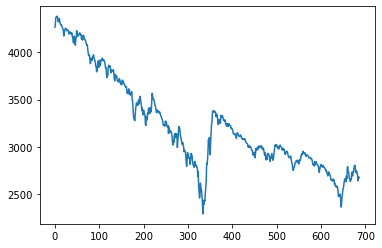

In [18]:
fig, ax = plt.subplots()
ax.plot('Open', data=sp500)
#ax.plot('Open', data=sp500.tail(1000))
plt.show()

In [19]:
l0, l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11 = list(),  list(), list(), list(), list(), list(), list(), list(), list(), list(), list(), list()
corr_btc_cur, corr_btc_df = list(),list()
corr_sp500_cur, corr_sp500_df = list(),list()
x = 2
for cnt, d in enumerate(rel_data): 
    #l0.append(d['market cap (USD)'].mean())
    l1.append(d.count(axis=0)[1])
    l2.append(d['open (USD)'].std())
    l3.append(d['open (USD)'].mean())
    
    std = d['spread'].std()
    mu = d['spread'].mean()
    l4.append(std)
    l5.append(mu)
    ss = 0
    for e in d['spread']:
        if (e > mu + x*std) or (e < mu - x*std):
            ss += 1
    l6.append(ss)
    l7.append(d.iat[0, 3] - d.iat[-1, 3])
    l8.append((d.iat[0, 3] - d.iat[-1, 3]) / d.count(axis=0)[1])
    c = time_corr(d, rel_data[currencies_list.index('BTC')])
    l9.append(c)
    if c < -0.5:
        corr_btc_cur.append(ouput_df.iloc[cnt, 0])
        corr_btc_df.append(d)
    
    c = time_corr_SP500(d, sp500)
    l10.append(c)
    if c < -0.5:
        corr_sp500_cur.append(ouput_df.iloc[cnt, 0])
        corr_sp500_df.append(d)
    l11 = d['timestamp'][0]

for cnt, d in enumerate(data): 
    l0.append(d['market cap (USD)'].mean())
    
ouput_df['avg market cap'] = l0    
ouput_df['observations'] = l1
ouput_df['std'] = l2
ouput_df['mean'] = l3
ouput_df['spread std'] = l4
ouput_df['spread mean'] = l5
ouput_df['outlier (3std)'] = l6
ouput_df['profit'] = l7
ouput_df['avg profit per day'] = l8
ouput_df['corr to BTC'] = l9
ouput_df['corr to S&P500'] = l10
ouput_df['last timestamp'] = l11

ouput_df

Something went wrong
Something went wrong


,currency,avg market cap,observations,std,mean,spread std,spread mean,outlier (3std),profit,avg profit per day,corr to BTC,corr to S&P500,last timestamp
0,AAVE,2.865326e+05,281,0.600026,1.015336,0.135120,0.144640,13,0.793216,0.002823,0.864717,0.701773,2021-07-22
1,ADA,3.317066e+08,1000,0.407515,0.243991,0.064980,0.027816,48,0.958953,0.000959,0.879853,0.820082,2021-07-22
2,AION,1.915401e+07,520,0.893351,1.299996,0.269136,0.202843,27,-1.253308,-0.002410,0.761753,0.575379,2021-07-22
3,ALGO,2.336447e+07,762,0.530713,0.697014,0.127183,0.091648,23,-3.448715,-0.004526,0.819493,0.675512,2021-07-22
4,ANT,1.066833e+06,344,0.737817,1.563257,0.652019,0.259721,2,-12.095321,-0.035161,0.658343,0.369356,2021-07-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,XZC,1.243922e+05,294,0.246341,1.022063,0.108304,0.103729,9,-0.349436,-0.001189,0.839770,-0.073107,2021-07-22
101,ZEC,2.001216e+05,855,0.543846,0.830596,0.123412,0.087524,31,0.386514,0.000452,0.850143,0.729264,2021-07-22
102,ZEN,2.300921e+05,382,0.782440,0.810260,0.165131,0.125770,24,0.874311,0.002289,0.791639,0.843463,2021-07-22
103,ZIL,2.467965e+08,885,0.918458,0.684451,0.171883,0.095302,45,0.689985,0.000780,0.959159,0.791340,2021-07-22


In [25]:
print('min obersations: {}'.format(ouput_df['observations'].min()))
print('max obersations: {}'.format(ouput_df['observations'].max()))

ouput_sorted = ouput_df.sort_values(['avg market cap', 'currency'], ascending=False)
ouput_sorted.head(10)

min obersations: 18
max obersations: 1000


,currency,avg market cap,observations,std,mean,spread std,spread mean,outlier (3std),profit,avg profit per day,corr to BTC,corr to S&P500,last timestamp
19,BTT,1.946660e+10,904,0.806825,0.536847,0.185340,0.074392,38,0.727358,0.000805,0.744274,0.604185,2021-07-22
69,NPXS,3.972223e+09,602,0.176529,0.072023,0.040501,0.012012,24,0.960244,0.001595,-0.103441,0.464906,2021-07-22
29,DENT,3.629096e+09,696,1.700348,0.807889,0.423276,0.160474,37,0.670500,0.000963,0.767398,0.584880,2021-07-22
32,DOGE,2.509966e+09,749,0.605600,0.265957,0.162520,0.050741,30,1.007404,0.001345,0.638779,0.686264,2021-07-22
90,VET,1.412235e+09,1000,0.661518,0.379231,0.141930,0.055437,40,0.849054,0.000849,0.832340,0.747769,2021-07-22
85,TRX,1.302617e+09,1000,0.484858,0.581799,0.091846,0.057461,45,0.559844,0.000560,0.836774,0.725157,2021-07-22
47,IOST,9.179381e+08,854,0.791273,0.708527,0.175567,0.097012,39,-0.463320,-0.000543,0.901989,0.683524,2021-07-22
77,SC,8.084490e+08,382,1.026796,1.026672,0.248763,0.161501,18,0.706419,0.001849,0.812175,0.712126,2021-07-22
61,MATIC,4.801401e+08,819,0.451258,0.196347,0.121786,0.036061,27,1.034449,0.001263,0.572532,0.681281,2021-07-22
97,XRP,3.891248e+08,1000,0.476582,0.674376,0.114870,0.069041,47,0.193774,0.000194,0.726475,0.630374,2021-07-22


Text(0, 0.5, 'Profit')

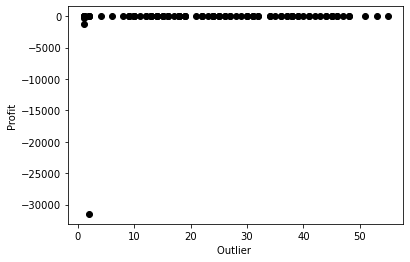

In [26]:
plt.scatter(ouput_df['outlier (3std)'], ouput_df['profit'], color='k')
plt.xlabel('Outlier ')
plt.ylabel('Profit')

In [27]:
print(currencies.loc[currencies['currency code'] == currencies_list[ouput_df['profit'].idxmin()]])
ouput_df_wo_ol = ouput_df.drop(ouput_df['profit'].idxmin(), axis=0)

print(currencies.loc[currencies['currency code'] == currencies_list[ouput_df_wo_ol['profit'].idxmin()]])
ouput_df_wo_ol = ouput_df_wo_ol.drop(ouput_df_wo_ol['profit'].idxmin(), axis=0)

print(currencies.loc[currencies['currency code'] == currencies_list[ouput_df_wo_ol['profit'].idxmin()]])
ouput_df_wo_ol = ouput_df_wo_ol.drop(ouput_df_wo_ol['profit'].idxmin(), axis=0)

print(currencies.loc[currencies['currency code'] == currencies_list[ouput_df_wo_ol['profit'].idxmin()]])
ouput_df_wo_ol = ouput_df_wo_ol.drop(ouput_df_wo_ol['profit'].idxmin(), axis=0)

print(currencies.loc[currencies['currency code'] == currencies_list[ouput_df_wo_ol['profit'].idxmin()]])
ouput_df_wo_ol = ouput_df_wo_ol.drop(ouput_df_wo_ol['profit'].idxmin(), axis=0)

print('average profit: {}'.format(ouput_df_wo_ol['profit'].mean()))

    currency code currency name
501           VEN       VeChain
    currency code currency name
288           MCO        Monaco
   currency code currency name
95          BUSD   Binance-USD
   currency code currency name
26           ANT        Aragon
    currency code currency name
193           FIL      Filecoin
average profit: 0.04280978894318746


Coefficients: 
 [[0.02576166]]


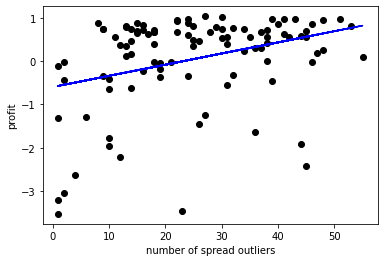

In [28]:
#data = pd.read_csv('data.csv')  # load data set
x = ouput_df_wo_ol['outlier (3std)'].values.reshape(-1, 1)
y = ouput_df_wo_ol['profit'].values.reshape(-1, 1)

linear_regressor = lm.LinearRegression()  # create object for the class
linear_regressor.fit(x, y)  # perform linear regression
y_pred = linear_regressor.predict(x)  # make predictions

print('Coefficients: \n', linear_regressor.coef_)
plt.scatter(x, y, color='k')
plt.plot(x, y_pred, color='b')
plt.xlabel('number of spread outliers')
plt.ylabel('profit')
plt.savefig(pathToSave.format('outlier_profit'))
plt.show()


In [29]:
scipy.__version__

'1.6.2'

(100, 1)
R² is: 0.13926800134457326
P-value that the slope is zero: 0.00013127382415777008
Coefficients: 
 [[0.00034696]]


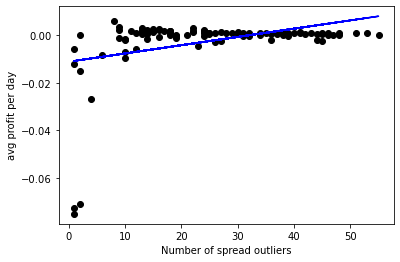

In [30]:
#data = pd.read_csv('data.csv')  # load data set
x = ouput_df_wo_ol['outlier (3std)'].values.reshape(-1, 1)
y = ouput_df_wo_ol['avg profit per day'].values.reshape(-1, 1)
print(y.shape)
#(slope, intercept, r_val, p_val) = scipy.stats.linregress(x,y)
#result = scipy.stats.linregress(np.asarray(x), np.asarray(y))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[:,0], y[:,0])
print(f'R² is: {r_value**2}')
print(f'P-value that the slope is zero: {p_value}')

linear_regressor = lm.LinearRegression()  # create object for the class
linear_regressor.fit(x, y)  # perform linear regression
y_pred = linear_regressor.predict(x)  # make predictions



print('Coefficients: \n', linear_regressor.coef_)
plt.scatter(x, y, color='k')
plt.plot(x, y_pred, color='b')
plt.xlabel('Number of spread outliers')
plt.ylabel('avg profit per day')
plt.savefig(pathToSave.format('outlier_profit_per_day'))
plt.show()


Coefficients: 
 [[-1.27403886e-11]]


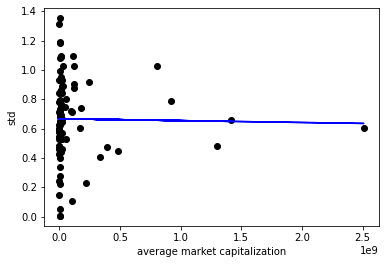

In [31]:
ouput_df_wo_olx = ouput_df_wo_ol.drop(ouput_df_wo_ol['avg market cap'].idxmax(), axis=0)
ouput_df_wo_olx = ouput_df_wo_olx.drop(ouput_df_wo_olx['avg market cap'].idxmax(), axis=0)
ouput_df_wo_olx = ouput_df_wo_olx.drop(ouput_df_wo_olx['avg market cap'].idxmax(), axis=0)
#ouput_df_wo_olx = ouput_df_wo_ol.drop(ouput_df_wo_olx['profit'].idxmax(), axis=0)
#ouput_df_wo_olx = ouput_df_wo_ol.drop(ouput_df_wo_olx['profit'].idxmax(), axis=0)
#ouput_df_wo_olx = ouput_df_wo_ol.drop(ouput_df_wo_olx['profit'].idxmax(), axis=0)
#plt.scatter(ouput_df_wo_olx['avg market cap'], ouput_df_wo_olx['std'], color='k')
#plt.scatter(ouput_df['avg market cap'], ouput_df['std'], color='k')
#plt.xlabel('Average market capitalisation')
#plt.ylabel('Profit')

#data = pd.read_csv('data.csv')  # load data set
x = ouput_df_wo_olx['avg market cap'].values.reshape(-1, 1)
y = ouput_df_wo_olx['std'].values.reshape(-1, 1)

linear_regressor = lm.LinearRegression()  # create object for the class
linear_regressor.fit(x, y)  # perform linear regression
y_pred = linear_regressor.predict(x)  # make predictions

print('Coefficients: \n', linear_regressor.coef_)
plt.scatter(x, y, color='k')
plt.plot(x, y_pred, color='b')
plt.xlabel('average market capitalization')
plt.ylabel('std')
plt.savefig(pathToSave.format('std_market_cap'))
plt.show()

Text(0, 0.5, 'Profit')

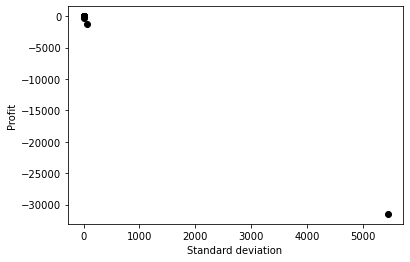

In [32]:
plt.scatter(ouput_df['std'], ouput_df['profit'], color='k')
plt.xlabel('Standard deviation ')
plt.ylabel('Profit')

Coefficients: 
 [[0.38398597]]


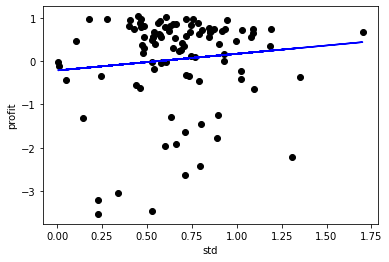

In [33]:
#data = pd.read_csv('data.csv')  # load data set
x = ouput_df_wo_ol['std'].values.reshape(-1, 1)
y = ouput_df_wo_ol['profit'].values.reshape(-1, 1)

linear_regressor = lm.LinearRegression()  # create object for the class
linear_regressor.fit(x, y)  # perform linear regression
y_pred = linear_regressor.predict(x)  # make predictions

print('Coefficients: \n', linear_regressor.coef_)
plt.scatter(x, y, color='k')
plt.plot(x, y_pred, color='b')
plt.xlabel('std')
plt.ylabel('profit')
plt.savefig(pathToSave.format('std_profit'))
plt.show()

R² is: 0.08648188852475383
P-value that the slope is zero: 0.002980227162866527
Coefficients: 
 [[0.01322314]]


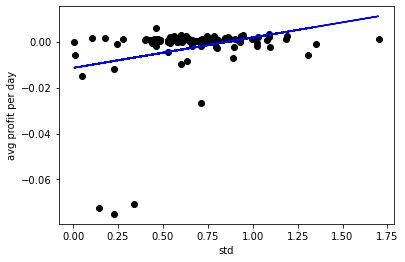

In [34]:
#data = pd.read_csv('data.csv')  # load data set
x = ouput_df_wo_ol['std'].values.reshape(-1, 1)
y = ouput_df_wo_ol['avg profit per day'].values.reshape(-1, 1)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[:,0], y[:,0])
print(f'R² is: {r_value**2}')
print(f'P-value that the slope is zero: {p_value}')

linear_regressor = lm.LinearRegression()  # create object for the class
linear_regressor.fit(x, y)  # perform linear regression
y_pred = linear_regressor.predict(x)  # make predictions

print('Coefficients: \n', linear_regressor.coef_)
plt.scatter(x, y, color='k')
plt.plot(x, y_pred, color='b')
plt.xlabel('std')
plt.ylabel('avg profit per day')
plt.savefig(pathToSave.format('std_profit_per_day'))
plt.show()

Text(0, 0.5, 'Profit')

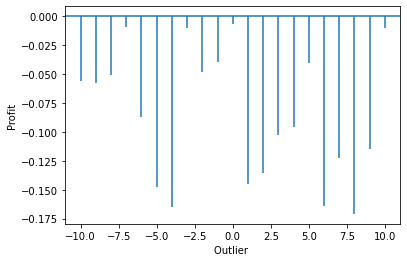

In [35]:
plt.xcorr(ouput_df['outlier (3std)'], ouput_df['profit'])
plt.xlabel('Outlier ')
plt.ylabel('Profit')

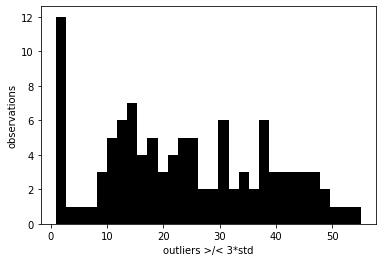

In [36]:
plt.hist(ouput_df['outlier (3std)'], bins=30, color='k')
plt.xlabel('outliers >/< 3*std')
plt.ylabel('observations')
plt.savefig(pathToSave.format('hist_outlier'))
plt.show()

/home/urmelie/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/urmelie/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


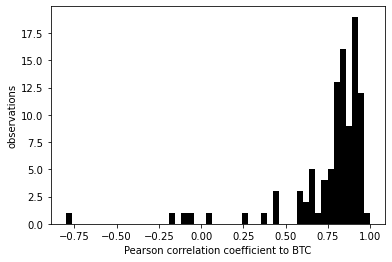

In [37]:
plt.hist(ouput_df['corr to BTC'],bins=50, color='k')
plt.xlabel('Pearson correlation coefficient to BTC')
plt.ylabel('observations')
plt.savefig(pathToSave.format('hist_corr_BTC'))
plt.show()

In [38]:
print(corr_btc_cur)
ouput_df.loc[ouput_df['currency'] == corr_btc_cur[0]]

['STRAT']


,currency,avg market cap,observations,std,mean,spread std,spread mean,outlier (3std),profit,avg profit per day,corr to BTC,corr to S&P500,last timestamp
82,STRAT,738964.286493,268,0.225078,0.787482,0.212159,0.092489,1,-3.192708,-0.011913,-0.800988,0.766671,2021-07-22


In [39]:
data_STRAT = pd.read_csv('cy_data/STRAT.csv')
data_STRAT.head(10)

,Unnamed: 0,timestamp,open (USD),high (USD),low (USD),close (USD),open (USD).1,high (USD).1,low (USD).1,close (USD).1,volume,market cap (USD)
0,0,2020-11-12,0.5376,0.5636,0.4904,0.4904,0.5376,0.5636,0.4904,0.4904,595797.17,595797.17
1,1,2020-11-11,0.5389,0.5997,0.5094,0.5399,0.5389,0.5997,0.5094,0.5399,924286.33,924286.33
2,2,2020-11-10,0.5181,0.6382,0.5012,0.5389,0.5181,0.6382,0.5012,0.5389,2558869.23,2558869.23
3,3,2020-11-09,0.4937,0.5500,0.4796,0.5190,0.4937,0.5500,0.4796,0.5190,986369.03,986369.03
4,4,2020-11-08,0.4362,0.4997,0.4360,0.4937,0.4362,0.4997,0.4360,0.4937,384443.46,384443.46
5,5,2020-11-07,0.4932,0.5153,0.4181,0.4394,0.4932,0.5153,0.4181,0.4394,1134832.86,1134832.86
6,6,2020-11-06,0.4720,0.5220,0.4524,0.4919,0.4720,0.5220,0.4524,0.4919,1304678.44,1304678.44
7,7,2020-11-05,0.4051,0.4750,0.3997,0.4750,0.4051,0.4750,0.3997,0.4750,1031255.69,1031255.69
8,8,2020-11-04,0.3680,0.4576,0.3583,0.4055,0.3680,0.4576,0.3583,0.4055,1916174.39,1916174.39
9,9,2020-11-03,0.3722,0.3849,0.3459,0.3682,0.3722,0.3849,0.3459,0.3682,649347.87,649347.87


/home/urmelie/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/urmelie/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


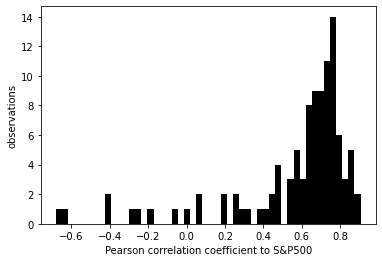

In [40]:
plt.hist(ouput_df['corr to S&P500'],bins=50, color='k') 
plt.xlabel('Pearson correlation coefficient to S&P500')
plt.ylabel('observations')
plt.savefig(pathToSave.format('hist_corr_SP500'))
plt.show()

In [41]:
print(corr_sp500_cur)
ouput_df.loc[ouput_df['currency'].isin(corr_sp500_cur)]

['BTG', 'XVG']


,currency,avg market cap,observations,std,mean,spread std,spread mean,outlier (3std),profit,avg profit per day,corr to BTC,corr to S&P500,last timestamp
17,BTG,1.022578e+05,98,0.712021,1.797726,0.323998,0.322055,4,-2.636120,-0.026899,0.931654,-0.643151,2021-07-22
99,XVG,2.210890e+08,47,0.228654,1.328095,0.430074,0.220866,1,-3.524432,-0.074988,0.813674,-0.679949,2021-07-22


In [42]:
used_currencies = currencies.loc[currencies['currency code'].isin(currencies_list)]
used_currencies.to_csv('{}.csv'.format('used_currencies'), encoding='utf-8')
ouput_df.to_csv('{}.csv'.format('output'), encoding='utf-8')

In [43]:
# https://www.alphavantage.co/documentation/#currency-daily
CSV_URL = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=GRT&datatype=csv&market=USD&apikey=E7BF5XXE8WRMMDOD'
download = requests.Session().get(CSV_URL).content
grt = pd.read_csv(io.StringIO(download.decode('utf-8')))
grt

,timestamp,open (USD),high (USD),low (USD),close (USD),open (USD).1,high (USD).1,low (USD).1,close (USD).1,volume,market cap (USD)
0,2021-11-22,0.92120,0.92540,0.89970,0.90650,0.92120,0.92540,0.89970,0.90650,2.396706e+06,2.396706e+06
1,2021-11-21,0.96580,0.96820,0.91940,0.92070,0.96580,0.96820,0.91940,0.92070,3.496184e+07,3.496184e+07
2,2021-11-20,0.95500,0.98620,0.91300,0.96490,0.95500,0.98620,0.91300,0.96490,3.162343e+07,3.162343e+07
3,2021-11-19,0.86740,0.97120,0.85490,0.95500,0.86740,0.97120,0.85490,0.95500,4.306902e+07,4.306902e+07
4,2021-11-18,0.93510,1.05050,0.84500,0.86760,0.93510,1.05050,0.84500,0.86760,8.476937e+07,8.476937e+07
...,...,...,...,...,...,...,...,...,...,...,...
336,2020-12-21,0.73726,0.77200,0.45000,0.47195,0.73726,0.77200,0.45000,0.47195,9.070190e+08,9.070190e+08
337,2020-12-20,0.47735,0.78300,0.45000,0.73826,0.47735,0.78300,0.45000,0.73826,1.865776e+09,1.865776e+09
338,2020-12-19,0.26097,0.58990,0.25522,0.47749,0.26097,0.58990,0.25522,0.47749,2.419430e+09,2.419430e+09
339,2020-12-18,0.12253,0.28665,0.12253,0.26122,0.12253,0.28665,0.12253,0.26122,1.898015e+09,1.898015e+09


In [44]:
#rel_sp500 = sp500.copy() 
#print(sp500)
#for d in rel_sp500: 
#    start = d.iat[0, 3]
#    #df = pd.read_csv(io.StringIO(download.decode('utf-8')))
#    d['Open'] /= start
#rel_data[0]

In [45]:
btc_strat = pd.read_csv('BTC_STRAT.csv') 
btc_strat.head()


,timestamp,STRAT,BTC
0,2020-11-12,0.5376,15684.25
1,2020-11-11,0.5389,15297.21
2,2020-11-10,0.5181,15328.41
3,2020-11-09,0.4937,15475.10
4,2020-11-08,0.4362,14818.30


In [46]:
ss = btc_strat['STRAT'][0]
btc_strat['STRAT'] /= ss

bs = btc_strat['BTC'][0]
btc_strat['BTC'] /= bs

print(btc_strat.head())
print(btc_strat.tail())
print(type(btc_strat))

    timestamp     STRAT       BTC
0  2020-11-12  1.000000  1.000000
1  2020-11-11  1.002418  0.975323
2  2020-11-10  0.963728  0.977312
3  2020-11-09  0.918341  0.986665
4  2020-11-08  0.811384  0.944789
      timestamp     STRAT       BTC
263  2020-02-23  0.839472  0.615321
264  2020-02-22  0.819940  0.616992
265  2020-02-21  0.812314  0.611901
266  2020-02-20  0.849144  0.611738
267  2020-02-19  0.849516  0.648088
<class 'pandas.core.frame.DataFrame'>


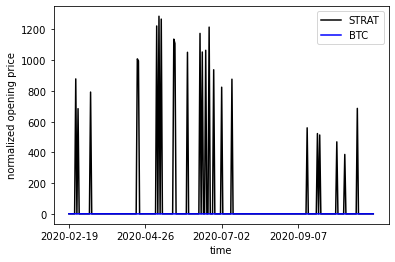

In [47]:
#btc_strat = btc_strat.iloc[::-1]
ax =  btc_strat.plot(color=['k','b'])
ax.set_xlabel("time")
#ax.set_xticklabels(['a', 'b'])

btc_strat = btc_strat.iloc[::-1]

xticks = btc_strat['timestamp']
tick_date = btc_strat['timestamp'].iloc(0)#, btc_strat['timestamp'].iloc(-1)]
print(tick_date)
ax.set_xticks(np.arange(len(xticks)))
#ax.tick_params(axis='x',which='major',direction='in',bottom=True,length=200)
#ax.set_xticklabels(xticks)
ax.set_xticklabels(xticks)
ax.locator_params(axis='x', nbins=4)


ax.set_ylabel("normalized opening price")
ax.figure.savefig('diagrams/btc_stat.png')

